In [1]:
import os

cache_dir ='/scratch/hakeem.at/Queryable-Shared-Reference-Repository/notebooks/pretrained_models'

os.environ['HF_HOME'] = cache_dir
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HUGGINGFACE_HUB_CACHE'] = cache_dir

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [4]:
df = pd.read_json("context_expansion_responses.jsonl",lines=True)
df.head()

,original_idx,source,question_type,query,original_context,expansion_type,target_pct,target_tokens,actual_tokens,ground_truth,raw_response
0,1500,Holzlechner et al. - 2017 - In Situ Characteri...,answerable,What is the DOI for the Supporting Information...,The Supporting Information is available free o...,top,0.1,3276,3385,The Supporting Information is available free o...,The DOI for the Supporting Information is 10.1...
1,1502,Holzlechner et al. - 2017 - In Situ Characteri...,unanswerable,What software was used to process the MALDI MS...,The Supporting Information is available free o...,bottom,0.1,3276,3754,None,I don't know.
2,1503,Cachier and Pennec - 2000 - 3D non-rigid regis...,answerable,What method was used to measure local variance...,Table /1 the derivative of the sum of local co...,bottom,0.1,3276,3350,cal variance using the difference of mean rela...,The method used to measure local variance usin...
3,1505,Cachier and Pennec - 2000 - 3D non-rigid regis...,unanswerable,What specific programming language was used to...,Table /1 the derivative of the sum of local co...,middle,0.1,3276,3925,None,
4,1506,Zhang et al. - 2023 - Single-cell lipidomics e...,answerable,What cell lines were obtained from American Ty...,For details about the chemicals used in the st...,top,0.1,3276,4075,"The commercial human cell lines, including pan...",The cell lines obtained from American Type Cul...


In [ ]:
# QUESTION_TYPES = ['answerable','unanswerable','borderline']

In [ ]:
# df = df[df['question_type']!=QUESTION_TYPES[1]]
# df.head()

In [5]:
def create_ground_truth_label(row):
    if row.question_type=='answerable':
        return 1
    else:
        return 0
df['ground_truth_label'] = df.apply(lambda x: create_ground_truth_label(x), axis=1)
df.head()

,original_idx,source,question_type,query,original_context,expansion_type,target_pct,target_tokens,actual_tokens,ground_truth,raw_response,ground_truth_label
0,1500,Holzlechner et al. - 2017 - In Situ Characteri...,answerable,What is the DOI for the Supporting Information...,The Supporting Information is available free o...,top,0.1,3276,3385,The Supporting Information is available free o...,The DOI for the Supporting Information is 10.1...,1
1,1502,Holzlechner et al. - 2017 - In Situ Characteri...,unanswerable,What software was used to process the MALDI MS...,The Supporting Information is available free o...,bottom,0.1,3276,3754,None,I don't know.,0
2,1503,Cachier and Pennec - 2000 - 3D non-rigid regis...,answerable,What method was used to measure local variance...,Table /1 the derivative of the sum of local co...,bottom,0.1,3276,3350,cal variance using the difference of mean rela...,The method used to measure local variance usin...,1
3,1505,Cachier and Pennec - 2000 - 3D non-rigid regis...,unanswerable,What specific programming language was used to...,Table /1 the derivative of the sum of local co...,middle,0.1,3276,3925,None,,0
4,1506,Zhang et al. - 2023 - Single-cell lipidomics e...,answerable,What cell lines were obtained from American Ty...,For details about the chemicals used in the st...,top,0.1,3276,4075,"The commercial human cell lines, including pan...",The cell lines obtained from American Type Cul...,1


In [6]:
NON_ANSWER_TEMPLATES = {
    "absence": [
        "The information is not mentioned in the document.",
        "This detail is not provided in the text.",
        "The document does not specify this information.",
        "There is no mention of this in the available content.",
    ],
    
    "uncertainty": [
        "I cannot determine this from the given information.",
        "It is unclear based on the available context.",
        "I don't have enough information to answer.",
        "Unable to find this information in the provided text.",
    ],
    
    "insufficient_evidence": [
        "The context does not contain sufficient details to answer.",
        "Based on the provided documents, I cannot answer this.",
        "The retrieved information is insufficient to respond.",
        "There isn't enough information in the sources to determine this.",
    ],
    
    "explicit_limitation": [
        "The document does not address this question.",
        "This topic is not covered in the available material.",
        "The text doesn't include information about this.",
        "This falls outside the scope of the provided documents.",
    ],
    
    "apologetic": [
        "I apologize, but I cannot find this information.",
        "Unfortunately, the document doesn't mention this.",
        "I'm unable to provide an answer based on the available text.",
        "Sorry, but this information is not present in the context.",
    ],
}

templates = [template for category_templates in NON_ANSWER_TEMPLATES.values() for template in category_templates]

In [10]:
model = SentenceTransformer('all-MiniLM-L6-v2', device="cuda")

In [12]:
template_embeddings = model.encode(templates)

In [13]:
def similarity_eval(raw_response, threshold=0.65):
    response_embedding = model.encode([raw_response])
    similarity = cosine_similarity(template_embeddings, response_embedding)
    score = similarity.max()
    if score>=threshold:
        return 0
    return 1

def create_prediction_label(row):
    if row.raw_response:
        if "i don't know" in row.raw_response.lower():
            return 0
        else:
            return similarity_eval(row.raw_response.lower())
    else:
        return 0
        
df['prediction_label'] = df.apply(lambda x: create_prediction_label(x), axis=1)
df.head()

,original_idx,source,question_type,query,original_context,expansion_type,target_pct,target_tokens,actual_tokens,ground_truth,raw_response,ground_truth_label,prediction_label
0,1500,Holzlechner et al. - 2017 - In Situ Characteri...,answerable,What is the DOI for the Supporting Information...,The Supporting Information is available free o...,top,0.1,3276,3385,The Supporting Information is available free o...,The DOI for the Supporting Information is 10.1...,1,1
1,1502,Holzlechner et al. - 2017 - In Situ Characteri...,unanswerable,What software was used to process the MALDI MS...,The Supporting Information is available free o...,bottom,0.1,3276,3754,None,I don't know.,0,0
2,1503,Cachier and Pennec - 2000 - 3D non-rigid regis...,answerable,What method was used to measure local variance...,Table /1 the derivative of the sum of local co...,bottom,0.1,3276,3350,cal variance using the difference of mean rela...,The method used to measure local variance usin...,1,1
3,1505,Cachier and Pennec - 2000 - 3D non-rigid regis...,unanswerable,What specific programming language was used to...,Table /1 the derivative of the sum of local co...,middle,0.1,3276,3925,None,,0,0
4,1506,Zhang et al. - 2023 - Single-cell lipidomics e...,answerable,What cell lines were obtained from American Ty...,For details about the chemicals used in the st...,top,0.1,3276,4075,"The commercial human cell lines, including pan...",The cell lines obtained from American Type Cul...,1,1


In [14]:
# PROMPT_TYPES = ['baseline','explicit_idk','confidence_threshold','confidence_rubric']

In [15]:
# df_baseline = df[df['prompt_type']==PROMPT_TYPES[0]]
# df_explicit_idk = df[df['prompt_type']==PROMPT_TYPES[1]]
# df_confidence_threshold = df[df['prompt_type']==PROMPT_TYPES[2]]
# df_confidence_rubric = df[df['prompt_type']==PROMPT_TYPES[3]]
# df_confidence_rubric.head()

## Answerable Vs Unanswerable

### Explicit I Don't Know - Baseline (Max 1024 Context Window)

In [38]:
ground_truth = df_explicit_idk['ground_truth_label']
predictions = df_explicit_idk['prediction_label']

accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7500
Precision: 0.9960
Recall:    0.5020
F1 Score:  0.6676


### Breakdown By PCT

In [18]:
metrics_by_pct = []
for target_pct, group in df.groupby('target_pct'):
    ground_truth = group['ground_truth_label']
    predictions = group['prediction_label']
    
    metrics_by_pct.append({
        'target_pct': target_pct,
        'context_tokens': group['target_tokens'].iloc[0],
        'n_samples': len(group),
        'accuracy': accuracy_score(ground_truth, predictions),
        'precision': precision_score(ground_truth, predictions, zero_division=0),
        'recall': recall_score(ground_truth, predictions, zero_division=0),
        'f1': f1_score(ground_truth, predictions, zero_division=0),
    })

metrics_df = pd.DataFrame(metrics_by_pct)
metrics_df

,target_pct,context_tokens,n_samples,accuracy,precision,recall,f1
0,0.10,3276,898,0.664811,0.930233,0.356347,0.515298
1,0.25,8192,898,0.569042,0.930556,0.149220,0.257198
2,0.50,16384,898,0.584633,0.975000,0.173719,0.294896
3,0.75,24576,898,0.552339,0.979592,0.106904,0.192771
4,0.95,31129,898,0.556793,1.000000,0.113586,0.204000


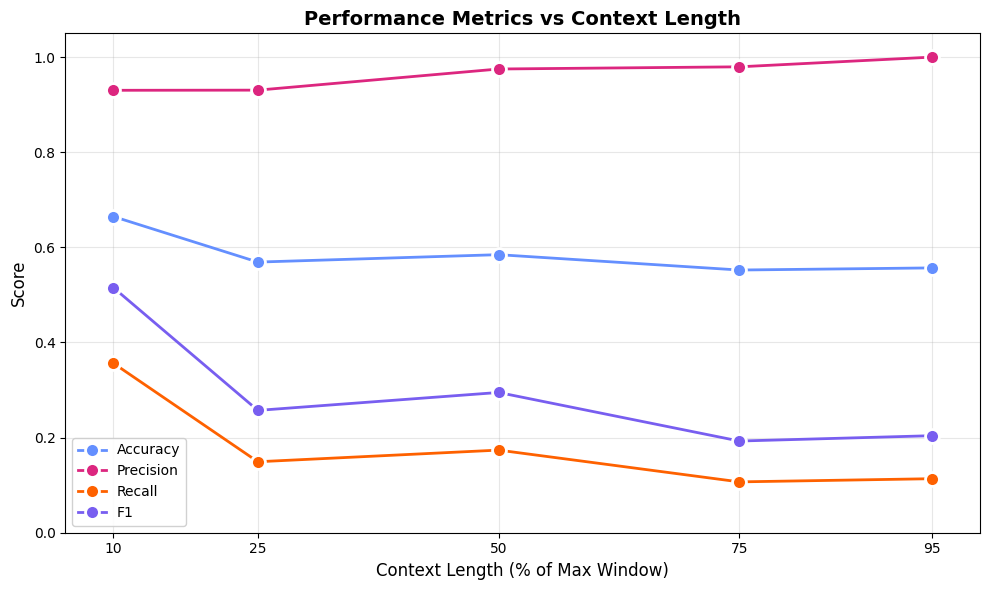


Optimal context length: 10% (3276 tokens)
F1 at optimal: 0.5153


In [30]:
colors = {
    'accuracy': '#648FFF',  
    'precision': '#DC267F',  
    'recall': '#FE6100',    
    'f1': '#785EF0',         
}

fig, ax = plt.subplots(figsize=(10, 6))

x = metrics_df['target_pct'].values * 100  

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    y = metrics_df[metric].values
    ax.plot(x, y, color=colors[metric], label=metric.capitalize(), linewidth=2, marker='o', 
            markersize=10, markeredgecolor='white', markeredgewidth=2)

ax.set_xlabel('Context Length (% of Max Window)', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics vs Context Length', fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(x.min() - 5, x.max() + 5)
ax.set_ylim(0, 1.05)
ax.set_xticks(x)

plt.tight_layout()
plt.savefig('context_length_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOptimal context length: {optimal_pct:.0f}% ({int(optimal_pct/100 * 32768)} tokens)")
print(f"F1 at optimal: {optimal_f1:.4f}")

In [ ]:
print("="*70)
print("Metrics by Expansion Type and Context Length")
print("="*70)

expansion_metrics = []

for expansion_type in df['expansion_type'].unique():
    subset = df[df['expansion_type'] == expansion_type]
    
    for target_pct, group in subset.groupby('target_pct'):
        gt = group['ground_truth_label']
        pred = group['prediction_label']
        
        answerable_subset = group[group['question_type'] == 'answerable']
        answer_rate = answerable_subset['prediction_label'].mean() if len(answerable_subset) > 0 else 0
        
        expansion_metrics.append({
            'expansion_type': expansion_type,
            'target_pct': target_pct,
            'accuracy': accuracy_score(gt, pred),
            'precision': precision_score(gt, pred, zero_division=0),
            'recall': recall_score(gt, pred, zero_division=0),
            'f1': f1_score(gt, pred, zero_division=0),
        })

expansion_df = pd.DataFrame(expansion_metrics)

# print("\nRecall by Position (where is the answer?):")
# # print(expansion_df.pivot(index='target_pct', columns='expansion_type', values='recall').round(3))

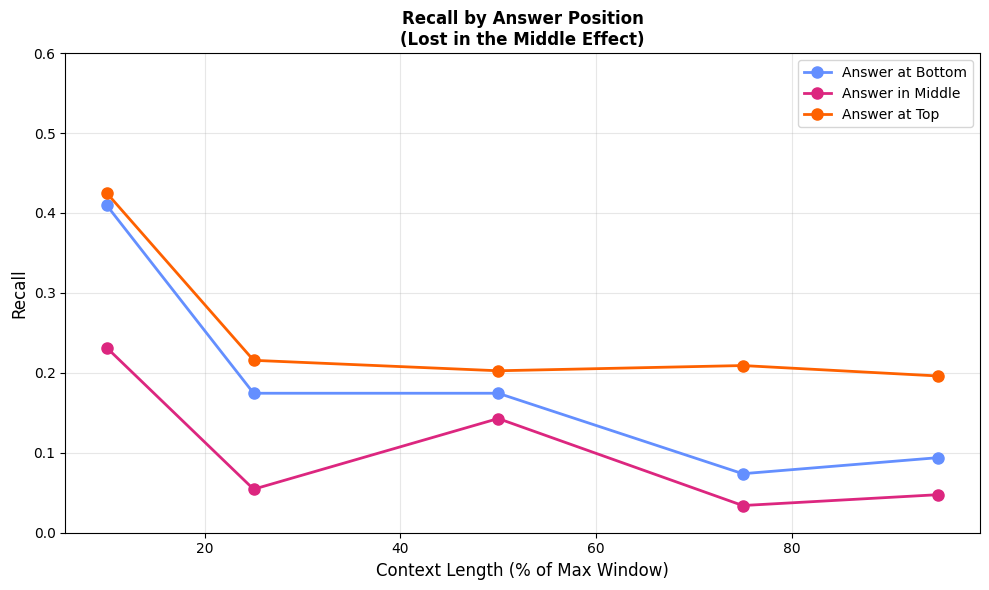

In [36]:
fig, axes = plt.subplots(figsize=(10,6))

colors_expansion = {
    'top': '#648FFF',     
    'middle': '#DC267F', 
    'bottom': '#FE6100',
}

ax1 = axes
for exp_type in ['top', 'middle', 'bottom']:
    subset = expansion_df[expansion_df['expansion_type'] == exp_type]
    x = subset['target_pct'].values * 100
    y = subset['recall'].values
    
    position_label = {'top': 'Answer at Bottom', 'middle': 'Answer in Middle', 'bottom': 'Answer at Top'}
    ax1.plot(x, y, color=colors_expansion[exp_type], label=position_label[exp_type], 
             linewidth=2, marker='o', markersize=8)

ax1.set_xlabel('Context Length (% of Max Window)', fontsize=12)
ax1.set_ylabel('Recall', fontsize=12)
ax1.set_title('Recall by Answer Position\n(Lost in the Middle Effect)', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 0.6)


plt.tight_layout()
plt.savefig('lost_in_middle_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

**Conclusion**

*Finding*
- In case of Qwen3 8B, as context length increases with `explicit IDK` prompt template, the model starts becoming more conservative.
- Rather than hallucination (as measured by precision), the model find answer as observed by the drop in recall. Precision shoots up not because model becomes hallucination prone at higher lengths rather simply because it's not answering most questions.
- This could be likely because there is much emphasis on "Instruction Following" at training and benchmarks that the model strongly focusses on the instruction and defaults to an easy answer "IDK" as it simply can't find the correct answer buried.
- Furthermore the phenomena of `Lost in the Middle` is clearly demonstrated here.

*Action*
- We could limit the conversation at 10% that is ~3.2K context length.
- However, it it's too restrictive, extensive context management has to be performed to ensure we stay within this limit.
- Additionally, for the user, try to front load important reference information otherwise you'll risk `Lost in the Middle` phenomena.